In [1]:
import pandas as pd
import numpy as np
import random
import os
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, SimpleRNN, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [2]:
random.seed(42) 
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# Define save directory to save models
save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)

# 1. Data Pre-Processing

In [4]:
# Load Data
file_path = 'GOOG.csv'
data = pd.read_csv(file_path)

# 1. Convert "Date" Column to date format and sort as dates ascending
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')
data = data.sort_values(by='Date')

# 2. Check and clean the anomalies
# Correct anomalies where Close > High
data['Close'] = data.apply(lambda x: x['High'] if x['Close'] > x['High'] else x['Close'], axis=1)

# Correct anomalies where  High < Low 
data['High'] = data.apply(lambda x: x['Low'] if x['High'] < x['Low'] else x['High'], axis=1)

# 3. Add New Feature
data['High-Low'] = data['High'] - data['Low']  # High-Low Price difference
data['Close-Open'] = data['Close'] - data['Open']  # Open-Close Price difference

# 4. Check the integrity of time series
date_range = pd.date_range(start=data['Date'].min(), end=data['Date'].max())
missing_dates = date_range.difference(data['Date'])
print("Missing Dates:", missing_dates, "\nThere are",len(missing_dates), "dates missing.")

# Fill in missing dates with NaNs
if not missing_dates.empty:
    data = data.set_index('Date').reindex(date_range).rename_axis('Date').reset_index()
    print("Missing dates are filled, and features filled as NaN.")

# 5. Check for missing values (These are the 2078 missing dates)
print("Missing values：")
print(data.isnull().sum())

# Fill missing values
data.ffill(inplace=True)

# 6. Data Normalisation
scaler = MinMaxScaler()
scaled_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'High-Low', 'Close-Open']
data[scaled_columns] = scaler.fit_transform(data[scaled_columns])

# Print data after clean
print("Cleaned Data：")
print(data.head())

Missing Dates: DatetimeIndex(['2004-08-21', '2004-08-22', '2004-08-28', '2004-08-29',
               '2004-09-04', '2004-09-05', '2004-09-06', '2004-09-11',
               '2004-09-12', '2004-09-18',
               ...
               '2022-11-13', '2022-11-19', '2022-11-20', '2022-11-24',
               '2022-11-26', '2022-11-27', '2022-12-03', '2022-12-04',
               '2022-12-10', '2022-12-11'],
              dtype='datetime64[ns]', length=2078, freq=None) 
There are 2078 dates missing.
Missing dates are filled, and features filled as NaN.
Missing values：
Date                 0
Low               2078
Open              2078
Volume            2078
High              2078
Close             2078
Adjusted Close    2078
High-Low          2078
Close-Open        2078
dtype: int64
Cleaned Data：
        Date       Low      Open    Volume      High     Close  \
0 2004-08-19  0.000000  0.000135  0.543577  0.000386  0.000055   
1 2004-08-20  0.000767  0.000303  0.277886  0.001222  0.001395   


# 2. Splitting Data

In [5]:
# Split dataset into training, validation, and test sets
train_size = int(len(data) * 0.8)  # 80% for train + validation
train_data = data[:train_size]
test_data = data[train_size:]  # 20% for test

# Further split train data into train and validation sets
val_size = int(len(train_data) * 0.2)  # 20% of train_data for validation
val_data = train_data[-val_size:]
train_data = train_data[:-val_size]

# print(len(data), len(train_data), len(val_data),len(test_data))
# print(train_data, val_data, test_data)

# 3. RNN Model Inputs

In [6]:
# Create sequences for time series prediction
def create_sequences(data, time_steps=12, forecast_steps=1, target_column='Close'):
    X, y = [], []
    for i in range(len(data) - time_steps - forecast_steps + 1):
        X.append(data.iloc[i:i + time_steps][scaled_columns].values)
        y.append(data.iloc[i + time_steps + forecast_steps - 1][target_column])
    return np.array(X), np.array(y)

time_steps = 12 # Use 12-day data to predict the 13th day price

# Create RNN input for train, validation, and test sets
train_X, train_y = create_sequences(train_data, time_steps)
val_X, val_y = create_sequences(val_data, time_steps)
test_X, test_y = create_sequences(test_data, time_steps)

# -------------------------- Adjust Data -----------------------------------
# Adjust data to ensure divisibility by batch size
def adjust_to_batch_size(data, batch_size):
    num_samples = len(data) - (len(data) % batch_size)
    return data[:num_samples]

batch_size = 32
train_X = adjust_to_batch_size(train_X, batch_size)
train_y = adjust_to_batch_size(train_y, batch_size)
val_X = adjust_to_batch_size(val_X, batch_size)
val_y = adjust_to_batch_size(val_y, batch_size)
test_X = adjust_to_batch_size(test_X, batch_size)
test_y = adjust_to_batch_size(test_y, batch_size)

print(f"Train X: {train_X.shape}, Train y: {train_y.shape}")
print(f"Validation X: {val_X.shape}, Validation y: {val_y.shape}")
print(f"Test X: {test_X.shape}, Test y: {test_y.shape}")


Train X: (4256, 12, 7), Train y: (4256,)
Validation X: (1056, 12, 7), Validation y: (1056,)
Test X: (1312, 12, 7), Test y: (1312,)


# 4. RNN Model Training & Tuning

In [7]:
from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'
rcParams['font.size'] = 20

# Function to calculate Mean Directional Accuracy (MDA)
def calculate_mda(y_true, y_pred):
    """
    Calculate Mean Directional Accuracy (MDA).
    y_true: Actual values
    y_pred: Predicted values
    """
    direction_true = np.sign(np.diff(y_true))
    direction_pred = np.sign(np.diff(y_pred))
    accuracy = np.mean(direction_true == direction_pred) * 100
    return accuracy

# Plot predictions with dates on the x-axis
def plot_predictions_with_dates(dates, actual, predicted, title, mse, mda, r2, model_type):
    """
    Plot actual vs predicted prices with dates on the x-axis.
    dates: Dates corresponding to the predictions
    actual: Actual values
    predicted: Predicted values
    title: Title of the plot
    mse: Mean Squared Error
    mda: Mean Directional Accuracy
    r2: R Squared
    model_type: The type of model used ('RNN', 'LSTM', 'GRU')
    """
    plt.figure(figsize=(12, 6))
    plt.plot(dates, actual, label='Actual', color='black', linewidth=2)
    plt.plot(dates, predicted, label=f'{model_type} Predicted', color='red', linestyle='--')
    plt.title(f"{title}\nMSE: {mse:.4f}, MDA: {mda:.2f}%, R²: {r2:.2f}", fontsize=20)
    plt.xlabel("Date", fontsize=20)
    plt.ylabel("Normalized Price", fontsize=20)
    plt.legend(fontsize=20)
    plt.grid()
    plt.xticks(fontsize=20, rotation=45)
    plt.yticks(fontsize=20)
    plt.tight_layout()
    plt.show()

# ---------------------- Training and Evaluation ----------------------
# Training and evaluation function
def train_and_evaluate(model_fn, model_types, input_shape, batch_size, save_dir):
    results = []
    val_dates_adjusted = val_data['Date'][time_steps:]  # Adjust validation set dates for alignment

    for model_name in model_types:
        print(f"Training {model_name}...")

        # Build the model
        model = model_fn(model_name, input_shape, batch_size)

        # Callback functions
        model_save_path = os.path.join(save_dir, f"{model_name}_best_model.keras")
        callbacks = [
            ModelCheckpoint(filepath=model_save_path, save_best_only=True, monitor='val_loss', verbose=1),
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
        ]

        # Train the model
        history = model.fit(
            train_X, train_y,
            validation_data=(val_X, val_y),
            epochs=50,
            batch_size=batch_size,
            shuffle=False,  # Must be False because stateful=True
            verbose=2,
            callbacks=callbacks
        )

        # Predict on validation set
        val_pred = model.predict(val_X, batch_size=batch_size).flatten()
        mse = mean_squared_error(val_y, val_pred)
        mda = calculate_mda(val_y, val_pred)
        r2 = r2_score(val_y, val_pred)

        # Save results
        results.append({"Model": model_name, "Validation MSE": mse, "Validation MDA (%)": mda, "R Squared": r2})

        # Plot predictions (adjust validation dates length to align with validation targets)
        plot_predictions_with_dates(
            val_dates_adjusted[:len(val_y)], val_y, val_pred,
            title=f"{model_name} Predictions vs Actual Prices", mse=mse, mda=mda, r2=r2, model_type=model_name
        )

    # Output results as a DataFrame
    results_df = pd.DataFrame(results)
    print(results_df)
    return results_df

## - Baseline Models

In [8]:
# ---------------------- Baseline Model Definition ----------------------
from tensorflow.keras.layers import Input

def build_model_baseline(model_type, input_shape, batch_size):
    """
    Baseline model with stateful=True
    """
    model = Sequential()
    # Add Input layer
    model.add(Input(batch_shape=(batch_size, input_shape[0], input_shape[1])))
    
    # Add RNN layer
    if model_type == 'RNN':
        model.add(SimpleRNN(50, activation='relu', stateful=True))
    elif model_type == 'LSTM':
        model.add(LSTM(50, activation='relu', stateful=True))
    elif model_type == 'GRU':
        model.add(GRU(50, activation='relu', stateful=True))
    else:
        raise ValueError("Invalid RNN type")
    
    # Add Dense output layer
    model.add(Dense(1))  # Predict a single output (Close price)
    
    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae']) # default learning rate is 0.001
    return model

# Baseline Vaninlla RNN: 50 neurons, ReLU
# Baseline LSTM: 50 neurons, ReLU
# Baseline GRU: 50 neurons, ReLU
# Optimizer: adam, defualt learning rate 0.001
# No additional hidden layer

Training RNN...
Epoch 1/50

Epoch 1: val_loss improved from inf to 0.00286, saving model to saved_models\RNN_best_model.keras
133/133 - 1s - 8ms/step - loss: 2.0318e-04 - mae: 0.0108 - val_loss: 0.0029 - val_mae: 0.0443 - learning_rate: 0.0010
Epoch 2/50

Epoch 2: val_loss improved from 0.00286 to 0.00077, saving model to saved_models\RNN_best_model.keras
133/133 - 0s - 2ms/step - loss: 3.8835e-04 - mae: 0.0126 - val_loss: 7.7073e-04 - val_mae: 0.0218 - learning_rate: 0.0010
Epoch 3/50

Epoch 3: val_loss improved from 0.00077 to 0.00047, saving model to saved_models\RNN_best_model.keras
133/133 - 0s - 2ms/step - loss: 2.1474e-04 - mae: 0.0093 - val_loss: 4.7254e-04 - val_mae: 0.0168 - learning_rate: 0.0010
Epoch 4/50

Epoch 4: val_loss improved from 0.00047 to 0.00039, saving model to saved_models\RNN_best_model.keras
133/133 - 0s - 2ms/step - loss: 1.2613e-04 - mae: 0.0070 - val_loss: 3.8966e-04 - val_mae: 0.0150 - learning_rate: 0.0010
Epoch 5/50

Epoch 5: val_loss did not improve fr

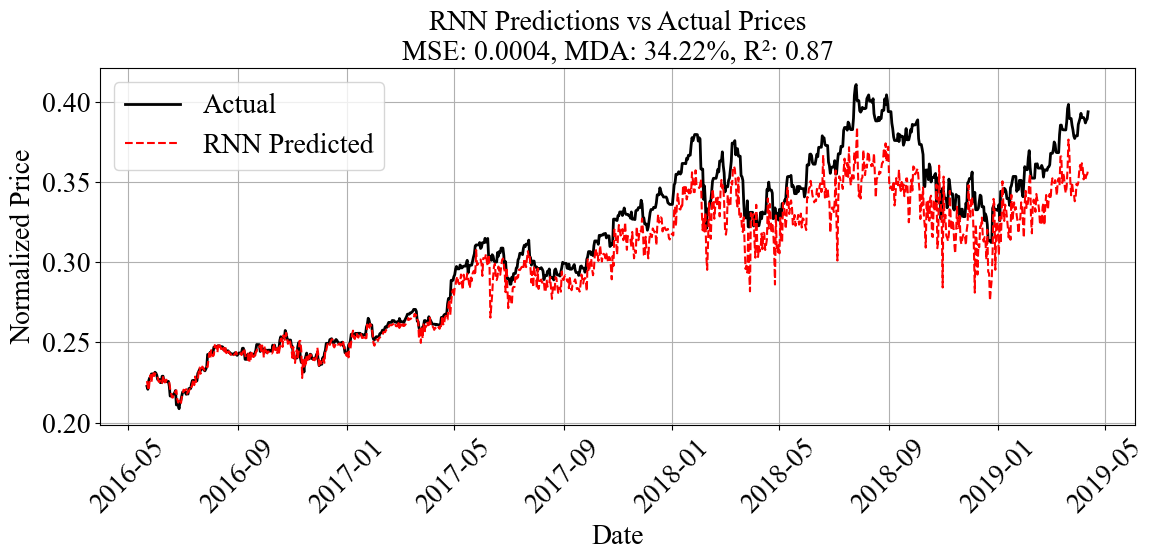

Training LSTM...
Epoch 1/50

Epoch 1: val_loss improved from inf to 0.00117, saving model to saved_models\LSTM_best_model.keras
133/133 - 1s - 9ms/step - loss: 3.1388e-04 - mae: 0.0145 - val_loss: 0.0012 - val_mae: 0.0291 - learning_rate: 0.0010
Epoch 2/50

Epoch 2: val_loss improved from 0.00117 to 0.00060, saving model to saved_models\LSTM_best_model.keras
133/133 - 0s - 2ms/step - loss: 6.7069e-04 - mae: 0.0168 - val_loss: 5.9593e-04 - val_mae: 0.0208 - learning_rate: 0.0010
Epoch 3/50

Epoch 3: val_loss improved from 0.00060 to 0.00020, saving model to saved_models\LSTM_best_model.keras
133/133 - 0s - 2ms/step - loss: 3.3488e-04 - mae: 0.0100 - val_loss: 2.0316e-04 - val_mae: 0.0117 - learning_rate: 0.0010
Epoch 4/50

Epoch 4: val_loss did not improve from 0.00020
133/133 - 0s - 2ms/step - loss: 4.1157e-05 - mae: 0.0044 - val_loss: 2.6382e-04 - val_mae: 0.0136 - learning_rate: 0.0010
Epoch 5/50

Epoch 5: val_loss did not improve from 0.00020
133/133 - 0s - 2ms/step - loss: 2.2561e-

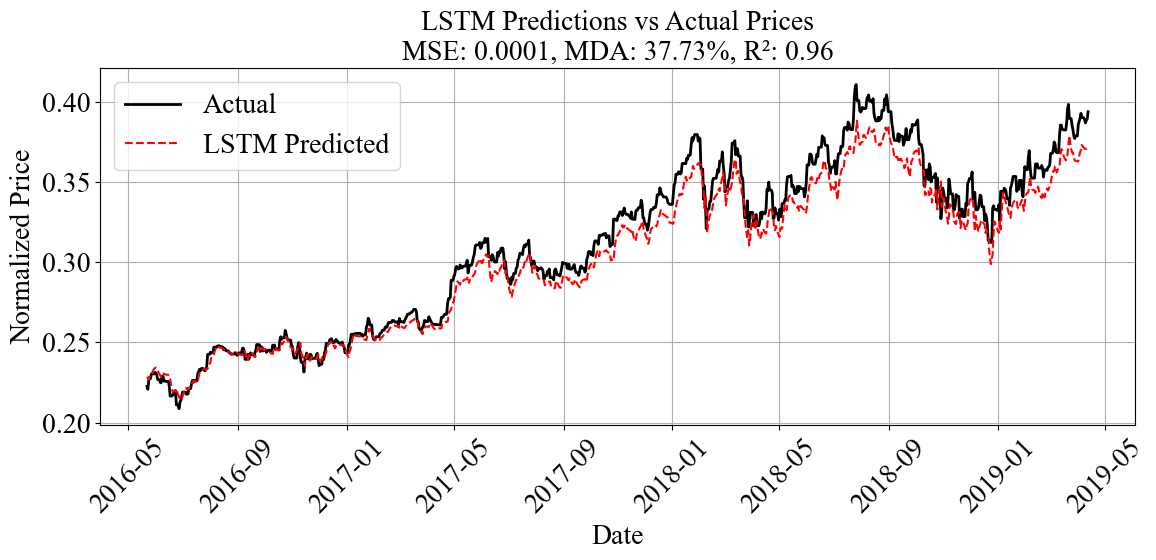

Training GRU...
Epoch 1/50

Epoch 1: val_loss improved from inf to 0.00277, saving model to saved_models\GRU_best_model.keras
133/133 - 1s - 10ms/step - loss: 1.9938e-04 - mae: 0.0108 - val_loss: 0.0028 - val_mae: 0.0424 - learning_rate: 0.0010
Epoch 2/50

Epoch 2: val_loss improved from 0.00277 to 0.00104, saving model to saved_models\GRU_best_model.keras
133/133 - 0s - 2ms/step - loss: 6.7170e-04 - mae: 0.0148 - val_loss: 0.0010 - val_mae: 0.0260 - learning_rate: 0.0010
Epoch 3/50

Epoch 3: val_loss did not improve from 0.00104
133/133 - 0s - 2ms/step - loss: 2.3585e-04 - mae: 0.0083 - val_loss: 0.0012 - val_mae: 0.0294 - learning_rate: 0.0010
Epoch 4/50

Epoch 4: val_loss improved from 0.00104 to 0.00095, saving model to saved_models\GRU_best_model.keras
133/133 - 0s - 2ms/step - loss: 3.2451e-05 - mae: 0.0039 - val_loss: 9.5490e-04 - val_mae: 0.0265 - learning_rate: 0.0010
Epoch 5/50

Epoch 5: val_loss did not improve from 0.00095
133/133 - 0s - 2ms/step - loss: 2.2849e-05 - mae: 0

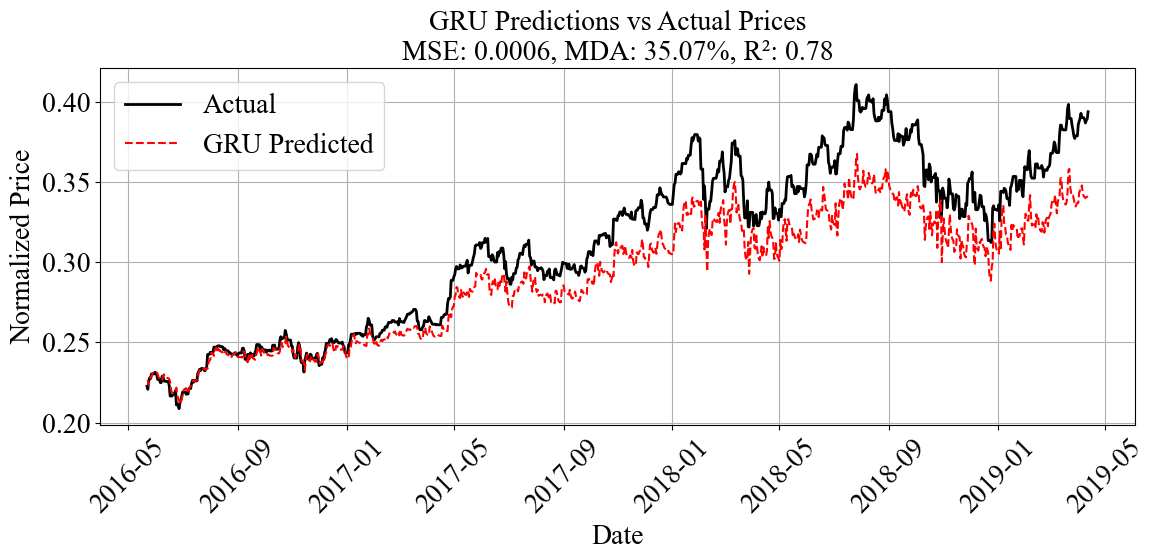

  Model  Validation MSE  Validation MDA (%)  R Squared
0   RNN        0.000354           34.218009   0.870348
1  LSTM        0.000121           37.725118   0.955737
2   GRU        0.000610           35.071090   0.776394


In [10]:
# Run Baseline Models
baseline_results = train_and_evaluate(
    build_model_baseline, 
    ['RNN', 'LSTM', 'GRU'], 
    input_shape=(train_X.shape[1], train_X.shape[2]), 
    batch_size=batch_size, 
    save_dir=save_dir
)

## - Tuned Models

### 1. Increased Neurons to 128, changed activation function and additional hidden layer before output

Training RNN...
Epoch 1/50

Epoch 1: val_loss improved from inf to 0.00743, saving model to saved_models\RNN_best_model.keras
133/133 - 1s - 10ms/step - loss: 0.0087 - mae: 0.0429 - val_loss: 0.0074 - val_mae: 0.0745 - learning_rate: 0.0010
Epoch 2/50

Epoch 2: val_loss improved from 0.00743 to 0.00619, saving model to saved_models\RNN_best_model.keras
133/133 - 0s - 2ms/step - loss: 9.1536e-04 - mae: 0.0213 - val_loss: 0.0062 - val_mae: 0.0669 - learning_rate: 0.0010
Epoch 3/50

Epoch 3: val_loss improved from 0.00619 to 0.00421, saving model to saved_models\RNN_best_model.keras
133/133 - 0s - 2ms/step - loss: 0.0012 - mae: 0.0223 - val_loss: 0.0042 - val_mae: 0.0558 - learning_rate: 0.0010
Epoch 4/50

Epoch 4: val_loss improved from 0.00421 to 0.00285, saving model to saved_models\RNN_best_model.keras
133/133 - 0s - 2ms/step - loss: 6.6786e-04 - mae: 0.0161 - val_loss: 0.0028 - val_mae: 0.0442 - learning_rate: 0.0010
Epoch 5/50

Epoch 5: val_loss improved from 0.00285 to 0.00255, sav

Epoch 36/50

Epoch 36: val_loss did not improve from 0.00008
133/133 - 0s - 2ms/step - loss: 6.1308e-06 - mae: 0.0018 - val_loss: 1.1518e-04 - val_mae: 0.0086 - learning_rate: 8.0000e-06
Epoch 37/50

Epoch 37: val_loss did not improve from 0.00008
133/133 - 0s - 2ms/step - loss: 6.0900e-06 - mae: 0.0018 - val_loss: 1.1520e-04 - val_mae: 0.0086 - learning_rate: 8.0000e-06
Epoch 38/50

Epoch 38: val_loss did not improve from 0.00008
133/133 - 0s - 2ms/step - loss: 5.8850e-06 - mae: 0.0017 - val_loss: 1.1381e-04 - val_mae: 0.0085 - learning_rate: 8.0000e-06
Epoch 39/50

Epoch 39: val_loss did not improve from 0.00008
133/133 - 0s - 2ms/step - loss: 5.8192e-06 - mae: 0.0017 - val_loss: 1.1192e-04 - val_mae: 0.0084 - learning_rate: 8.0000e-06
Epoch 40/50

Epoch 40: val_loss did not improve from 0.00008

Epoch 40: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
133/133 - 0s - 2ms/step - loss: 5.7921e-06 - mae: 0.0017 - val_loss: 1.0985e-04 - val_mae: 0.0083 - learning_rat

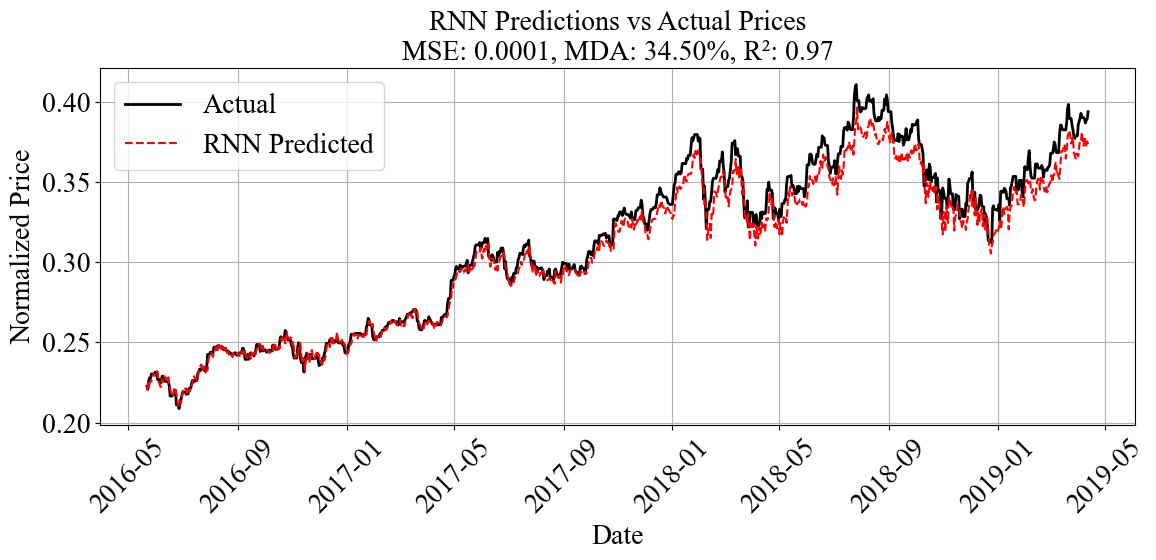

Training LSTM...
Epoch 1/50

Epoch 1: val_loss improved from inf to 0.00548, saving model to saved_models\LSTM_best_model.keras
133/133 - 2s - 12ms/step - loss: 7.1750e-04 - mae: 0.0200 - val_loss: 0.0055 - val_mae: 0.0662 - learning_rate: 0.0010
Epoch 2/50

Epoch 2: val_loss improved from 0.00548 to 0.00210, saving model to saved_models\LSTM_best_model.keras
133/133 - 1s - 4ms/step - loss: 8.2222e-04 - mae: 0.0209 - val_loss: 0.0021 - val_mae: 0.0377 - learning_rate: 0.0010
Epoch 3/50

Epoch 3: val_loss improved from 0.00210 to 0.00071, saving model to saved_models\LSTM_best_model.keras
133/133 - 1s - 4ms/step - loss: 8.6017e-04 - mae: 0.0197 - val_loss: 7.1155e-04 - val_mae: 0.0234 - learning_rate: 0.0010
Epoch 4/50

Epoch 4: val_loss improved from 0.00071 to 0.00031, saving model to saved_models\LSTM_best_model.keras
133/133 - 1s - 4ms/step - loss: 7.9142e-04 - mae: 0.0174 - val_loss: 3.1337e-04 - val_mae: 0.0153 - learning_rate: 0.0010
Epoch 5/50

Epoch 5: val_loss improved from 0.

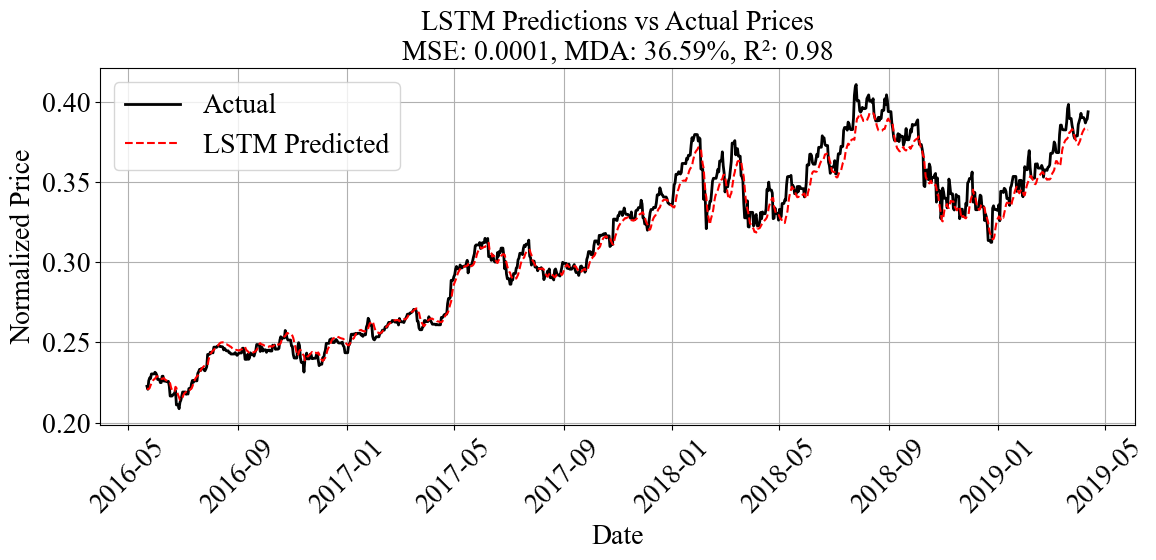

Training GRU...
Epoch 1/50

Epoch 1: val_loss improved from inf to 0.00236, saving model to saved_models\GRU_best_model.keras
133/133 - 2s - 12ms/step - loss: 3.9699e-04 - mae: 0.0148 - val_loss: 0.0024 - val_mae: 0.0429 - learning_rate: 0.0010
Epoch 2/50

Epoch 2: val_loss improved from 0.00236 to 0.00175, saving model to saved_models\GRU_best_model.keras
133/133 - 0s - 3ms/step - loss: 3.2732e-04 - mae: 0.0126 - val_loss: 0.0017 - val_mae: 0.0363 - learning_rate: 0.0010
Epoch 3/50

Epoch 3: val_loss did not improve from 0.00175
133/133 - 0s - 3ms/step - loss: 3.9420e-04 - mae: 0.0147 - val_loss: 0.0018 - val_mae: 0.0353 - learning_rate: 0.0010
Epoch 4/50

Epoch 4: val_loss improved from 0.00175 to 0.00125, saving model to saved_models\GRU_best_model.keras
133/133 - 0s - 4ms/step - loss: 3.9440e-04 - mae: 0.0133 - val_loss: 0.0012 - val_mae: 0.0288 - learning_rate: 0.0010
Epoch 5/50

Epoch 5: val_loss did not improve from 0.00125
133/133 - 0s - 3ms/step - loss: 3.8256e-04 - mae: 0.012

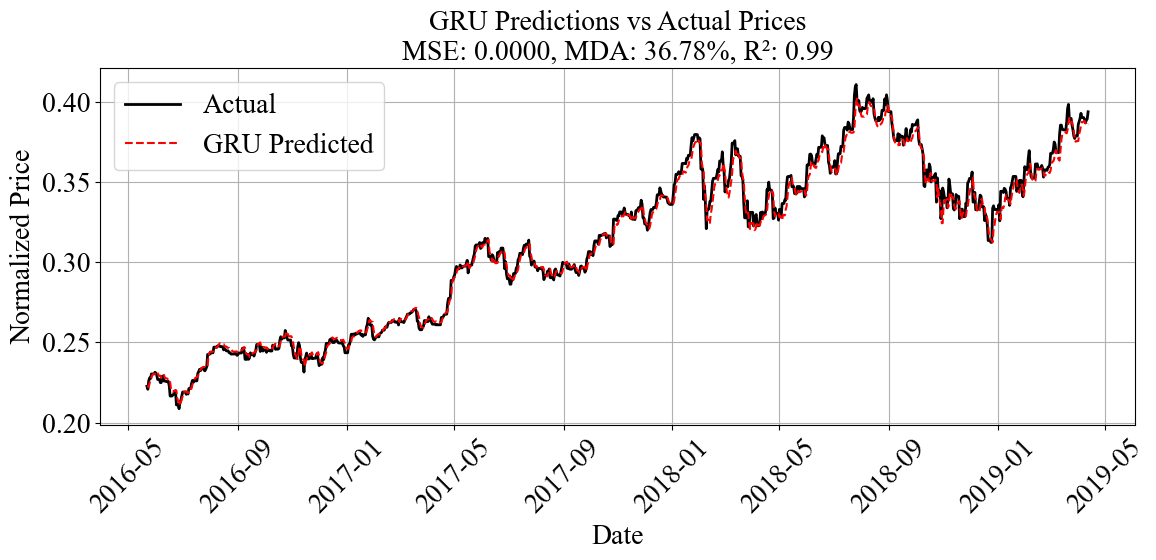

  Model  Validation MSE  Validation MDA (%)  R Squared
0   RNN        0.000081           34.502370   0.970285
1  LSTM        0.000055           36.587678   0.979952
2   GRU        0.000024           36.777251   0.991238


In [11]:
# Tune RNN, LSTM, GRU
# ---------------------- Tuned Model 1 Definition ----------------------
from tensorflow.keras.layers import Input

def build_model_tuned1(model_type, input_shape, batch_size):
    model = Sequential()
    
    # Add Input layer with defined input shape
    model.add(Input(batch_shape=(batch_size, input_shape[0], input_shape[1])))
    
    # Add the recurrent layer based on the model_type
    if model_type == 'RNN':
        model.add(SimpleRNN(128, activation='tanh', stateful=True))  # RNN layer
    elif model_type == 'LSTM':
        model.add(LSTM(128, activation='tanh', stateful=True))  # LSTM layer
    elif model_type == 'GRU':
        model.add(GRU(128, activation='tanh', stateful=True))  # GRU layer
    else:
        raise ValueError("Invalid RNN type")  # Raise an error for unsupported types
    
    # Add a hidden layer and the output layer
    model.add(Dense(32, activation='tanh'))  # Hidden layer with 32 units
    model.add(Dense(1))  # Output layer to predict the next closing price
    
    # Compile the model with Adam optimizer and mean squared error loss
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  loss='mse', 
                  metrics=['mae'])  # Metric: Mean Absolute Error
    return model

# ---------------------- Run Tuned Models 1 ----------------------
tuned1_results = train_and_evaluate(
    build_model_tuned1,  # Function to build the tuned model
    ['RNN', 'LSTM', 'GRU'],  # List of model types to train
    input_shape=(train_X.shape[1], train_X.shape[2]),  # Input shape (time_steps, features)
    batch_size=32,  # Batch size for training
    save_dir=save_dir  # Directory to save the model weights
)

# Vaninlla RNN: 128 neurons, Tanh
# Tuned LSTM: 128 neurons, Tanh
# Tuned GRU: 128 neurons, Tanh
# Optimizer: adam, learning rate = 0.001
# Additional hidden layer before output layer

### 2. Added Regularisation (Dropout)

In [13]:
# ---------------------- Tuned Model 2 Definition ----------------------
from tensorflow.keras.layers import Input, Dropout

def build_model_tuned2(model_type, input_shape, batch_size):
    model = Sequential()
    
    # Add Input layer with explicitly defined input shape
    model.add(Input(batch_shape=(batch_size, input_shape[0], input_shape[1])))
    
    # Add the recurrent layer and Dropout based on the model_type
    if model_type == 'RNN':
        model.add(SimpleRNN(128, activation='tanh', stateful=True))  # RNN layer
        model.add(Dropout(0.2))  # Add Dropout layer
    elif model_type == 'LSTM':
        model.add(LSTM(128, activation='tanh', stateful=True))  # LSTM layer
        model.add(Dropout(0.2))
    elif model_type == 'GRU':
        model.add(GRU(128, activation='tanh', stateful=True))  # GRU layer
        model.add(Dropout(0.2))
    else:
        raise ValueError("Invalid RNN type")  # Raise an error for unsupported types
    
    # Add a hidden layer and Dropout for further regularization
    model.add(Dense(32, activation='tanh'))  # Hidden layer with 32 units
    model.add(Dropout(0.2))  # Add Dropout layer
    model.add(Dense(1))  # Output layer to predict the next closing price
    
    # Compile the model with Adam optimizer and mean squared error loss
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  loss='mse', 
                  metrics=['mae'])  # Metric: Mean Absolute Error
    return model

Training RNN...
Epoch 1/50

Epoch 1: val_loss improved from inf to 0.00554, saving model to saved_models\RNN_best_model.keras
133/133 - 1s - 10ms/step - loss: 0.0231 - mae: 0.1013 - val_loss: 0.0055 - val_mae: 0.0579 - learning_rate: 0.0010
Epoch 2/50

Epoch 2: val_loss improved from 0.00554 to 0.00223, saving model to saved_models\RNN_best_model.keras
133/133 - 0s - 2ms/step - loss: 0.0055 - mae: 0.0543 - val_loss: 0.0022 - val_mae: 0.0354 - learning_rate: 0.0010
Epoch 3/50

Epoch 3: val_loss improved from 0.00223 to 0.00129, saving model to saved_models\RNN_best_model.keras
133/133 - 0s - 2ms/step - loss: 0.0037 - mae: 0.0438 - val_loss: 0.0013 - val_mae: 0.0275 - learning_rate: 0.0010
Epoch 4/50

Epoch 4: val_loss improved from 0.00129 to 0.00070, saving model to saved_models\RNN_best_model.keras
133/133 - 0s - 2ms/step - loss: 0.0018 - mae: 0.0314 - val_loss: 7.0197e-04 - val_mae: 0.0199 - learning_rate: 0.0010
Epoch 5/50

Epoch 5: val_loss improved from 0.00070 to 0.00048, saving 

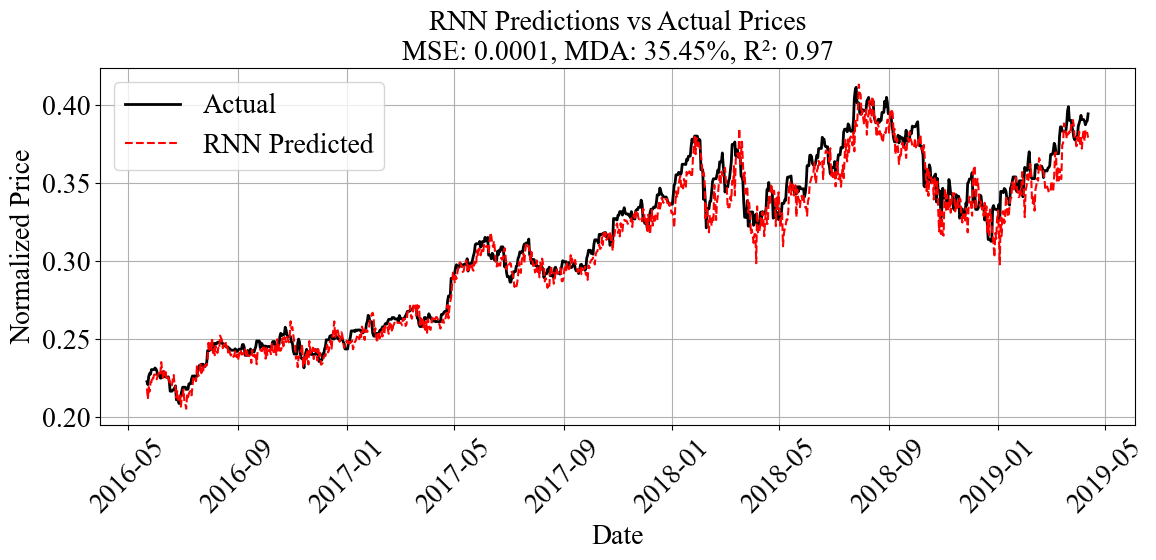

Training LSTM...
Epoch 1/50

Epoch 1: val_loss improved from inf to 0.00405, saving model to saved_models\LSTM_best_model.keras
133/133 - 2s - 13ms/step - loss: 0.0014 - mae: 0.0267 - val_loss: 0.0040 - val_mae: 0.0582 - learning_rate: 0.0010
Epoch 2/50

Epoch 2: val_loss improved from 0.00405 to 0.00152, saving model to saved_models\LSTM_best_model.keras
133/133 - 1s - 4ms/step - loss: 5.5559e-04 - mae: 0.0181 - val_loss: 0.0015 - val_mae: 0.0324 - learning_rate: 0.0010
Epoch 3/50

Epoch 3: val_loss improved from 0.00152 to 0.00146, saving model to saved_models\LSTM_best_model.keras
133/133 - 1s - 4ms/step - loss: 5.1797e-04 - mae: 0.0165 - val_loss: 0.0015 - val_mae: 0.0311 - learning_rate: 0.0010
Epoch 4/50

Epoch 4: val_loss improved from 0.00146 to 0.00088, saving model to saved_models\LSTM_best_model.keras
133/133 - 1s - 4ms/step - loss: 5.6923e-04 - mae: 0.0168 - val_loss: 8.7924e-04 - val_mae: 0.0248 - learning_rate: 0.0010
Epoch 5/50

Epoch 5: val_loss improved from 0.00088 to

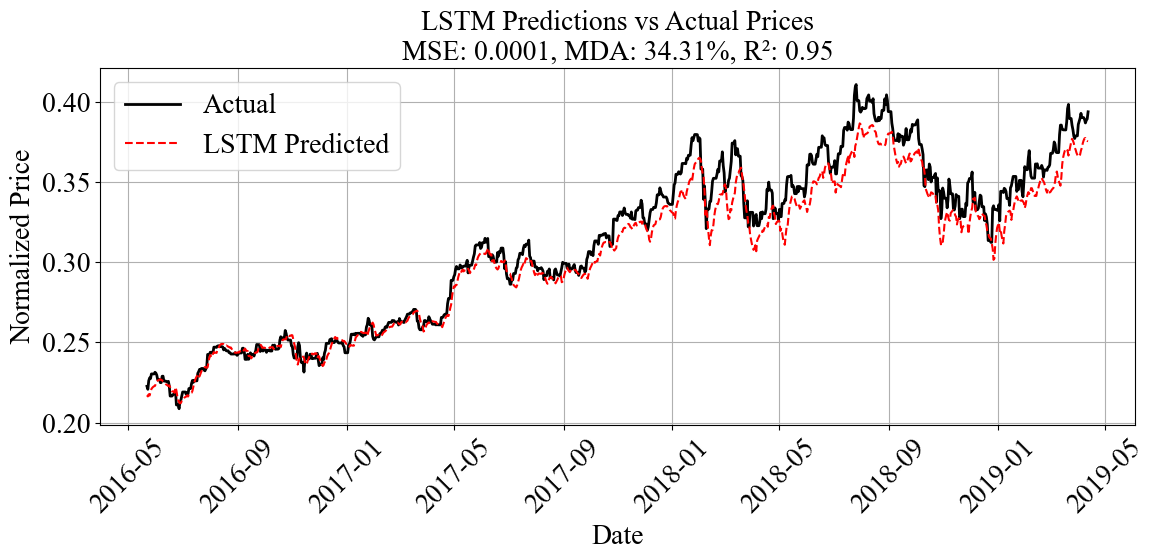

Training GRU...
Epoch 1/50

Epoch 1: val_loss improved from inf to 0.00430, saving model to saved_models\GRU_best_model.keras
133/133 - 2s - 13ms/step - loss: 0.0015 - mae: 0.0294 - val_loss: 0.0043 - val_mae: 0.0572 - learning_rate: 0.0010
Epoch 2/50

Epoch 2: val_loss improved from 0.00430 to 0.00204, saving model to saved_models\GRU_best_model.keras
133/133 - 0s - 4ms/step - loss: 8.6906e-04 - mae: 0.0213 - val_loss: 0.0020 - val_mae: 0.0370 - learning_rate: 0.0010
Epoch 3/50

Epoch 3: val_loss improved from 0.00204 to 0.00058, saving model to saved_models\GRU_best_model.keras
133/133 - 0s - 4ms/step - loss: 8.8086e-04 - mae: 0.0206 - val_loss: 5.8140e-04 - val_mae: 0.0210 - learning_rate: 0.0010
Epoch 4/50

Epoch 4: val_loss improved from 0.00058 to 0.00047, saving model to saved_models\GRU_best_model.keras
133/133 - 0s - 4ms/step - loss: 6.2476e-04 - mae: 0.0169 - val_loss: 4.7491e-04 - val_mae: 0.0179 - learning_rate: 0.0010
Epoch 5/50

Epoch 5: val_loss improved from 0.00047 to 

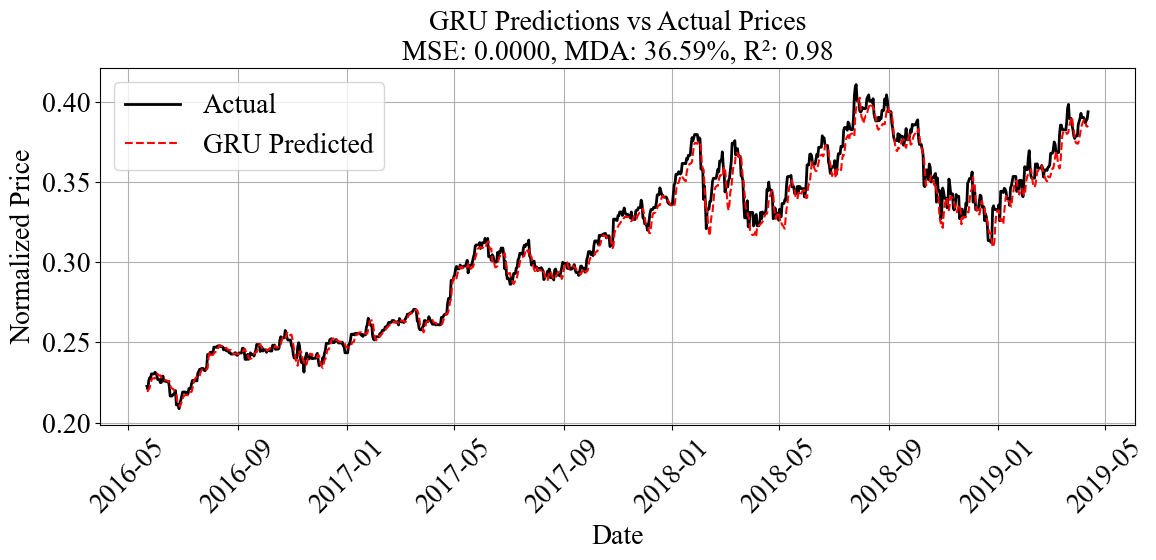

  Model  Validation MSE  Validation MDA (%)  R Squared
0   RNN        0.000092           35.450237   0.966413
1  LSTM        0.000147           34.312796   0.946214
2   GRU        0.000041           36.587678   0.984925


In [14]:
# Run Tuned Model 2
tuned2_results = train_and_evaluate(
    build_model_tuned2, 
    ['RNN', 'LSTM', 'GRU'], 
    input_shape=(train_X.shape[1], train_X.shape[2]), 
    batch_size=32, 
    save_dir=save_dir
)

# 5. Final Model

In [16]:
# Best Model
# Vaninlla RNN: 128 neurons, activation function = tanh, additional hidden layer, dropout (0.2)
def best_vanilla_rnn(input_shape, batch_size):
    model = Sequential()
    model.add(Input(batch_shape=(batch_size, input_shape[0], input_shape[1])))
    model.add(SimpleRNN(128, activation='tanh', stateful=True))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model


# LSTM: 128 neurons, activation function = tanh, additional hidden layer, no dropout
def best_lstm(input_shape, batch_size):
    model = Sequential()
    model.add(Input(batch_shape=(batch_size, input_shape[0], input_shape[1])))
    model.add(LSTM(128, activation='tanh', stateful=True))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model


# GRU: 128 neurons, activation function = tanh, additional hidden layer, dropout before output layer rate = 0.2
def best_gru(input_shape, batch_size):
    model = Sequential()
    model.add(Input(batch_shape=(batch_size, input_shape[0], input_shape[1])))
    model.add(GRU(128, activation='tanh', stateful=True))
    model.add(Dense(32, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

Training RNN...
Epoch 1/50

Epoch 1: val_loss improved from inf to 0.00285, saving model to saved_models\RNN_best_model.keras
133/133 - 1s - 10ms/step - loss: 0.0120 - mae: 0.0746 - val_loss: 0.0029 - val_mae: 0.0416 - learning_rate: 0.0010
Epoch 2/50

Epoch 2: val_loss improved from 0.00285 to 0.00115, saving model to saved_models\RNN_best_model.keras
133/133 - 0s - 2ms/step - loss: 0.0030 - mae: 0.0393 - val_loss: 0.0012 - val_mae: 0.0258 - learning_rate: 0.0010
Epoch 3/50

Epoch 3: val_loss improved from 0.00115 to 0.00089, saving model to saved_models\RNN_best_model.keras
133/133 - 0s - 2ms/step - loss: 0.0019 - mae: 0.0317 - val_loss: 8.9284e-04 - val_mae: 0.0235 - learning_rate: 0.0010
Epoch 4/50

Epoch 4: val_loss improved from 0.00089 to 0.00053, saving model to saved_models\RNN_best_model.keras
133/133 - 0s - 2ms/step - loss: 0.0011 - mae: 0.0245 - val_loss: 5.2821e-04 - val_mae: 0.0178 - learning_rate: 0.0010
Epoch 5/50

Epoch 5: val_loss improved from 0.00053 to 0.00045, sav

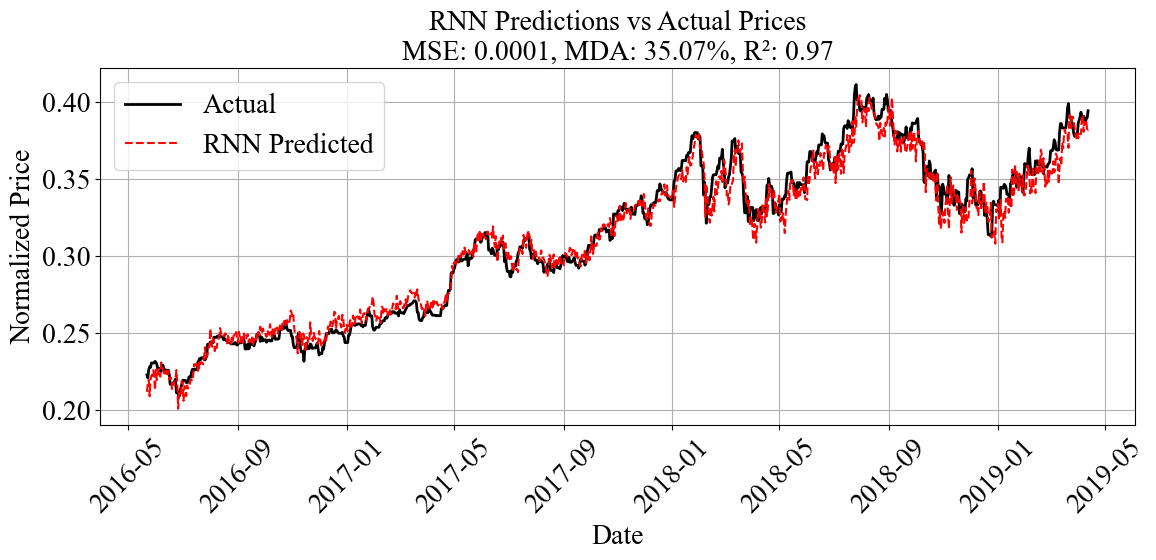

Training LSTM...
Epoch 1/50

Epoch 1: val_loss improved from inf to 0.00450, saving model to saved_models\LSTM_best_model.keras
133/133 - 2s - 12ms/step - loss: 4.5708e-04 - mae: 0.0159 - val_loss: 0.0045 - val_mae: 0.0585 - learning_rate: 0.0010
Epoch 2/50

Epoch 2: val_loss improved from 0.00450 to 0.00149, saving model to saved_models\LSTM_best_model.keras
133/133 - 1s - 4ms/step - loss: 6.4662e-04 - mae: 0.0180 - val_loss: 0.0015 - val_mae: 0.0327 - learning_rate: 0.0010
Epoch 3/50

Epoch 3: val_loss improved from 0.00149 to 0.00054, saving model to saved_models\LSTM_best_model.keras
133/133 - 1s - 4ms/step - loss: 7.9826e-04 - mae: 0.0186 - val_loss: 5.4446e-04 - val_mae: 0.0205 - learning_rate: 0.0010
Epoch 4/50

Epoch 4: val_loss improved from 0.00054 to 0.00032, saving model to saved_models\LSTM_best_model.keras
133/133 - 1s - 4ms/step - loss: 5.6391e-04 - mae: 0.0143 - val_loss: 3.2283e-04 - val_mae: 0.0152 - learning_rate: 0.0010
Epoch 5/50

Epoch 5: val_loss improved from 0.

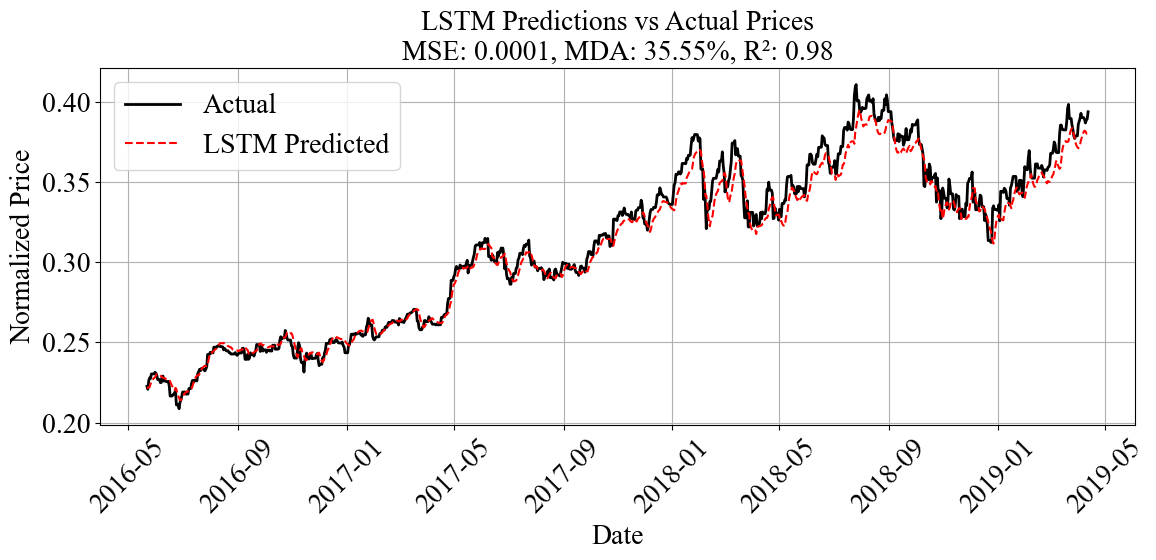

Training GRU...
Epoch 1/50

Epoch 1: val_loss improved from inf to 0.00566, saving model to saved_models\GRU_best_model.keras
133/133 - 2s - 13ms/step - loss: 9.3183e-04 - mae: 0.0222 - val_loss: 0.0057 - val_mae: 0.0683 - learning_rate: 0.0010
Epoch 2/50

Epoch 2: val_loss improved from 0.00566 to 0.00280, saving model to saved_models\GRU_best_model.keras
133/133 - 1s - 4ms/step - loss: 8.1339e-04 - mae: 0.0213 - val_loss: 0.0028 - val_mae: 0.0450 - learning_rate: 0.0010
Epoch 3/50

Epoch 3: val_loss improved from 0.00280 to 0.00134, saving model to saved_models\GRU_best_model.keras
133/133 - 0s - 4ms/step - loss: 7.3117e-04 - mae: 0.0191 - val_loss: 0.0013 - val_mae: 0.0303 - learning_rate: 0.0010
Epoch 4/50

Epoch 4: val_loss improved from 0.00134 to 0.00052, saving model to saved_models\GRU_best_model.keras
133/133 - 0s - 4ms/step - loss: 7.3789e-04 - mae: 0.0187 - val_loss: 5.2172e-04 - val_mae: 0.0197 - learning_rate: 0.0010
Epoch 5/50

Epoch 5: val_loss did not improve from 0.00

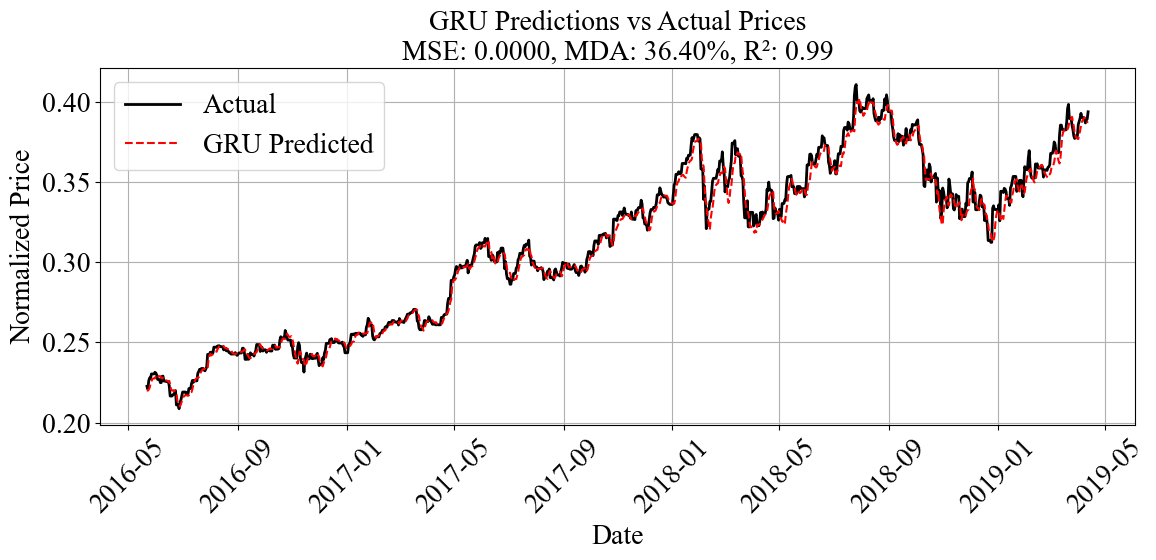

  Model  Validation MSE  Validation MDA (%)  R Squared
0   RNN        0.000078           35.071090   0.971233
1  LSTM        0.000064           35.545024   0.976515
2   GRU        0.000032           36.398104   0.988138


In [17]:
# Define a wrapper to use specific best model functions
def train_best_models(input_shape, batch_size, save_dir):
    # The list of best models and their names
    best_models = [
        ("RNN", best_vanilla_rnn(input_shape, batch_size)),
        ("LSTM", best_lstm(input_shape, batch_size)),
        ("GRU", best_gru(input_shape, batch_size)),
    ]
    
    results = []
    val_dates_adjusted = val_data['Date'][time_steps:]  # Adjust Validation Set Length
    
    for model_name, model in best_models:
        print(f"Training {model_name}...")
        
        # Callbacks
        model_save_path = os.path.join(save_dir, f"{model_name}_best_model.keras")
        callbacks = [
            ModelCheckpoint(filepath=model_save_path, save_best_only=True, monitor='val_loss', verbose=1),
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1),
        ]

        # Train model
        history = model.fit(
            train_X, train_y,
            validation_data=(val_X, val_y),
            epochs=50,
            batch_size=batch_size,
            shuffle=False,  # Required for stateful=True
            verbose=2,
            callbacks=callbacks
        )

        # Validation predictions
        val_pred = model.predict(val_X, batch_size=batch_size).flatten()
        mse = mean_squared_error(val_y, val_pred)
        mda = calculate_mda(val_y, val_pred)
        r2 = r2_score(val_y, val_pred)  # Calculate R Squared

        # Save results
        results.append({"Model": model_name, "Validation MSE": mse, "Validation MDA (%)": mda, "R Squared": r2})

        # Plot predictions
        plot_predictions_with_dates(
            val_dates_adjusted[:len(val_y)], val_y, val_pred,
            title=f"{model_name} Predictions vs Actual Prices", mse=mse, mda=mda, r2=r2, model_type=model_name
        )

    # Output results
    results_df = pd.DataFrame(results)
    print(results_df)
    return results_df

# Call the function for the best models
best_model_results = train_best_models(
    input_shape=(train_X.shape[1], train_X.shape[2]), 
    batch_size=32, 
    save_dir=save_dir
)


133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step


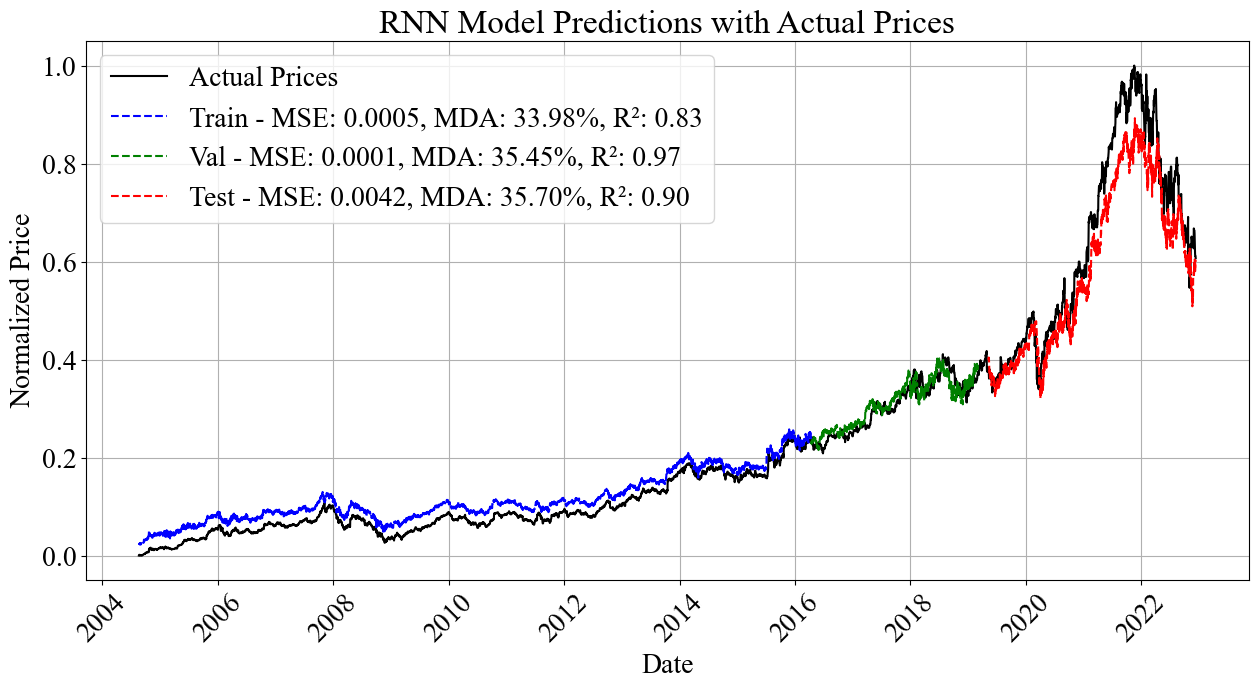

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


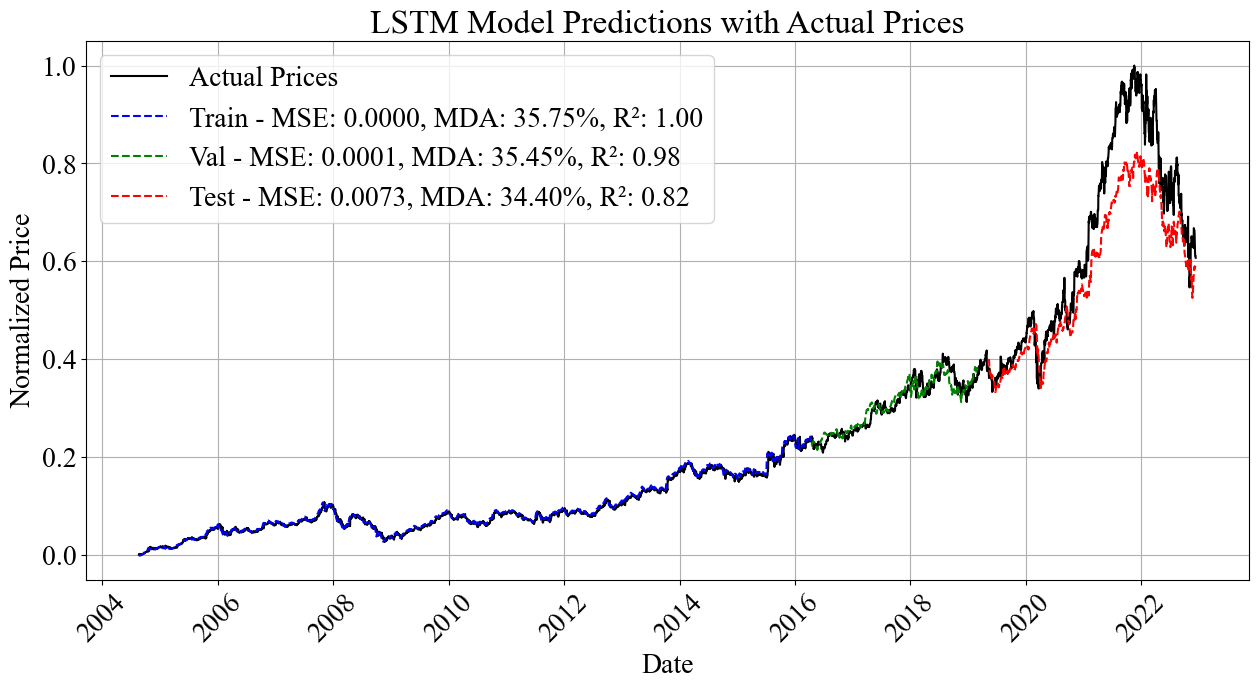

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


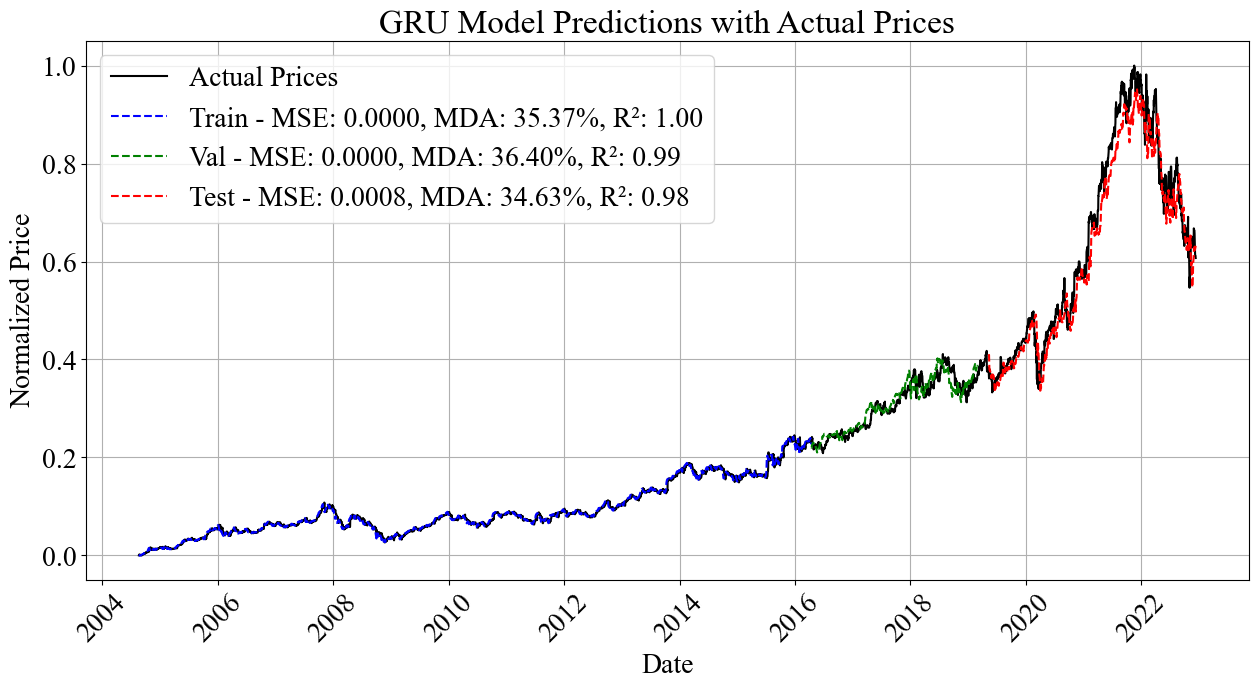

  Model  Train MSE  Train MDA (%)  Train R²   Val MSE  Val MDA (%)    Val R²  \
0   RNN   0.000530      33.983549  0.826566  0.000092    35.450237  0.966339   
1  LSTM   0.000012      35.746181  0.996015  0.000064    35.450237  0.976441   
2   GRU   0.000006      35.370153  0.998062  0.000032    36.398104  0.988138   

   Test MSE  Test MDA (%)   Test R²  
0  0.004178     35.697941  0.898552  
1  0.007325     34.401220  0.822125  
2  0.000791     34.630053  0.980787  


In [18]:
# ---------------------- Final Model Reporting ----------------------
# Load the best model for prediction and evaluation
def evaluate_final_model(model_path, model_type, test_X, test_y, train_X, train_y, val_X, val_y, full_dates, full_prices, time_steps, batch_size):
    # Load the saved model
    model = tf.keras.models.load_model(model_path)
    
    # Predict on train, validation, and test sets
    train_pred = model.predict(train_X, batch_size=batch_size).flatten()
    val_pred = model.predict(val_X, batch_size=batch_size).flatten()
    test_pred = model.predict(test_X, batch_size=batch_size).flatten()
    
    # Calculate MSE, MDA and R2 for each set
    train_mse = mean_squared_error(train_y, train_pred)
    val_mse = mean_squared_error(val_y, val_pred)
    test_mse = mean_squared_error(test_y, test_pred)

    train_mda = calculate_mda(train_y, train_pred)
    val_mda = calculate_mda(val_y, val_pred)
    test_mda = calculate_mda(test_y, test_pred)
    
    train_r2 = r2_score(train_y, train_pred)
    val_r2 = r2_score(val_y, val_pred)
    test_r2 = r2_score(test_y, test_pred)
    
    # Create labels for the legend
    train_label = f"Train - MSE: {train_mse:.4f}, MDA: {train_mda:.2f}%, R²: {train_r2:.2f}"
    val_label = f"Val - MSE: {val_mse:.4f}, MDA: {val_mda:.2f}%, R²: {val_r2:.2f}"
    test_label = f"Test - MSE: {test_mse:.4f}, MDA: {test_mda:.2f}%, R²: {test_r2:.2f}"
    actual_label = "Actual Prices"
    
    # Plot predictions for the entire time series
    plt.figure(figsize=(15, 7))
    # All actual close prices
    plt.plot(full_dates, full_prices, label=actual_label, color='black', linewidth=1.5)
    # Training set predicted prices
    plt.plot(full_dates[:len(train_pred)], train_pred, label=train_label, color='blue', linestyle='--')
    # Validation set predicted prices
    plt.plot(full_dates[len(train_pred):len(train_pred) + len(val_pred)], val_pred, label=val_label, color='green', linestyle='--')
    # Testing set predicted prices
    plt.plot(full_dates[-len(test_pred):], test_pred, label=test_label, color='red', linestyle='--') 
    
    plt.title(f"{model_type} Model Predictions with Actual Prices")
    plt.xlabel("Date")
    plt.ylabel("Normalized Price")
    plt.legend()
    plt.grid()
    plt.xticks(rotation=45)
    plt.show()

    # Return results as a dictionary
    return {
        "Model": model_type,
        "Train MSE": train_mse, "Train MDA (%)": train_mda, "Train R²": train_r2,
        "Val MSE": val_mse, "Val MDA (%)": val_mda, "Val R²": val_r2,
        "Test MSE": test_mse, "Test MDA (%)": test_mda, "Test R²": test_r2
    }

# ---------------------- Final Evaluation ----------------------
final_results = []

# Combine all dates and actual prices (train, validation, and test sets)
full_dates = pd.concat([train_data['Date'], val_data['Date'], test_data['Date']]).values
full_prices = pd.concat([train_data['Close'], val_data['Close'], test_data['Close']]).values

# Define paths to the best models for each type
best_models = {
    "RNN": "saved_models/RNN_best_model.keras",
    "LSTM": "saved_models/LSTM_best_model.keras",
    "GRU": "saved_models/GRU_best_model.keras"
}

# Evaluate each model type
for model_type, model_path in best_models.items():
    results = evaluate_final_model(
        model_path=model_path, 
        model_type=model_type, 
        test_X=test_X, test_y=test_y, 
        train_X=train_X, train_y=train_y, 
        val_X=val_X, val_y=val_y, 
        full_dates=full_dates, 
        full_prices=full_prices, 
        time_steps=time_steps, 
        batch_size=batch_size
    )
    final_results.append(results)

# Convert results to a DataFrame for output
final_results_df = pd.DataFrame(final_results)
print(final_results_df)


# 6. Trading Strategy

In [19]:
import pandas as pd
import numpy as np

# Trading strategy implementation
def trading_strategy(model, test_X, test_y, initial_cost=10000, transaction_cost=0.001):
    """
    Simulates a trading strategy using the model's predictions.
    
    Parameters:
    - model: Trained model for predictions
    - test_X: Test features
    - test_y: Actual test labels (true close prices)
    - initial_cost: Initial investment amount in USD
    - transaction_cost: Percentage cost per transaction

    Returns:
    - A dictionary with final portfolio value and trading summary
    """
    # Initialize variables
    cash = initial_cost
    shares_held = 0
    portfolio_values = []
    trading_history = []

    for i in range(len(test_X) - 1):  # Exclude the last day (no prediction available for tomorrow)
        # Predict close price for today and tomorrow
        P_close_pred_today = model.predict(test_X[i:i+1], batch_size=1).flatten()[0]
        P_open_today = test_X[i, 0, 0]  # Open price is the first feature in test_X

        # Trading conditions
        # Buy: if predicted close price is higher than today's open price + transaction cost
        if P_close_pred_today > P_open_today * (1 + transaction_cost):
            # Buy 5% of cash worth of shares
            shares_to_buy = (0.05 * cash) / P_open_today
            cost = shares_to_buy * P_open_today * (1 + transaction_cost)
            if cost <= cash:  # Check if enough cash is available
                cash -= cost
                shares_held += shares_to_buy
                trading_history.append({'Action': 'Buy', 'Shares': shares_to_buy, 'Price': P_open_today})

        # Sell: if predicted close price for tomorrow is lower than today's close price
        elif P_close_pred_today < test_y[i] * (1 - transaction_cost) and shares_held > 0:
            # Sell all shares
            revenue = shares_held * P_open_today * (1 - transaction_cost)
            cash += revenue
            trading_history.append({'Action': 'Sell', 'Shares': shares_held, 'Price': P_open_today})
            shares_held = 0

        # Calculate portfolio value (cash + current value of held shares)
        portfolio_value = cash + shares_held * P_open_today
        portfolio_values.append(portfolio_value)

    # Final portfolio value
    final_value = cash + shares_held * test_y[-1]
    profit_loss = final_value - initial_cost

    return {
        "Final Portfolio Value": final_value,
        "Profit/Loss": profit_loss,
        "Trading History": pd.DataFrame(trading_history),
        "Portfolio Values": portfolio_values
    }

# Run trading strategy for each best model
test_results = {}
models = {
    "RNN": best_vanilla_rnn(input_shape=(test_X.shape[1], test_X.shape[2]), batch_size=32),
    "LSTM": best_lstm(input_shape=(test_X.shape[1], test_X.shape[2]), batch_size=32),
    "GRU": best_gru(input_shape=(test_X.shape[1], test_X.shape[2]), batch_size=32),
}

for model_name, model in models.items():
    print(f"Running trading strategy for {model_name}...")
    # Load best weights
    model.load_weights(os.path.join(save_dir, f"{model_name}_best_model.keras"))
    
    # Simulate trading strategy
    results = trading_strategy(model, test_X, test_y)
    
    # Store results
    test_results[model_name] = results
    print(f"{model_name} - Final Portfolio Value: ${results['Final Portfolio Value']:.2f}")
    print(f"{model_name} - Profit/Loss: ${results['Profit/Loss']:.2f}")

# Summarize results in a DataFrame
summary = pd.DataFrame({
    "Model": list(test_results.keys()),
    "Final Portfolio Value": [test_results[m]["Final Portfolio Value"] for m in test_results],
    "Profit/Loss": [test_results[m]["Profit/Loss"] for m in test_results]
})
print(summary)


Running trading strategy for RNN...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

C:\Users\Lucia\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━